In [1]:
import numpy as np
import pandas as pd
import tushare as ts
import datetime as datetime
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.decomposition

In [2]:
# handle raw data
def handle_data_from_excel(data_file_name):
    with pd.ExcelFile(data_file_name) as xls:
            data = pd.read_excel(xls, "Sheet1", index_col=None, na_values=['NA'])
    data.fillna(method='pad', inplace= True) #Replaces missing values with the previous one.
    data.drop('CEI',1, inplace = True) #Drops indicator we don't need

    macro_data = data[['CPI','MCI','PPI','HS300 Index Return']] #create separate macro indicators table.
    data.drop(['CPI','MCI','PPI','HS300 Index Return'],1)

    datat = data.drop(['CPI','MCI','PPI','HS300 Index Return'],1, inplace=True) #create two parallel time series, one at time t and other at time t+1
    datat = data.shift(-1)
    datat.drop(['Date'],1,inplace= True)
    datat = datat.rename(columns={'CCI':'CCIt',
                    'SMT':'SMTt',
                    'NumIPO':'NumIPOt',
                    'NewAcc':'NewAcct',
                    'DiscCEF':'DiscCEFt',
                    'ADR':'ADRt'})
    datat.fillna(method='pad', inplace= True)
    all_data = pd.concat([data,datat,macro_data],1) #join all the data in one dataframe
    selected_data = all_data[['CCI', 'SMTt', 'NumIPOt', 'NewAcc', 'DiscCEF', 'ADRt', 'CPI','MCI','PPI','HS300 Index Return']]
    return selected_data.values

def get_sentiment_residual(sentiment, macros):
    #regress sentiment on macros
    
    return sm.OLS(sentiment, sm.add_constant(macros)).fit().resid

# perform regression on every sentiment indicator
def get_residuals(sentiments, macros, regression_method):
    
    #return a residual matrix
    
    residuals = []
    for n in range(0, sentiments.shape[1]):
        residuals.append(regression_method(sentiments[:,n], macros))
    return np.array(residuals).transpose()  # convert to ndarray

# construct indicator
def construct_indicator(sentiment_residuals):
    """ PCA on scaled sentiment residuals
    the estimated number of components set to 4
    use PCA component factors with max variance
    """
    scaled_data = sklearn.preprocessing.scale(sentiment_residuals)  # normalize
    pca = sklearn.decomposition.PCA(n_components=4) # n_components set to 4
    pca.fit(scaled_data).transform(scaled_data)
    return np.dot(scaled_data, pca.components_[0,:].transpose())

In [3]:
# roll month by month
# data fetcher with moving window
class MovingWindow:
    """ False as default to use fixed window,
     set to true to use growing window
    """
    def __init__(self, payload, initial_window_size, change_size=True):
        self.payload = payload
        self.length = len(payload)  # exceptions: assume time spread by row here
        self.window_size = initial_window_size
        self.change_size = change_size

    def __iter__(self):
        self.window_end = self.window_size  # exceptions: may excess payload length
        return self
    
    def __next__(self):
        window_end = self.window_end
        window_start = 0
        if not self.change_size:
            window_start = window_end - self.window_size
        if self.window_end > self.length:
            raise StopIteration
        self.window_end += 1    # growth rate set to 1
        return self.payload[window_start:window_end,:]

In [4]:
def test_strategy(market_data):
    data = pd.DataFrame(market_data, columns=['Market Sentiment','HS300 Index Return'])
    
    data['Average Sentiment'] = [data.loc[0:i, "Market Sentiment"].mean() for i in range(data.shape[0])]
    data['st.D of Sentiment'] = [data.loc[0:i, "Market Sentiment"].std() for i in range(data.shape[0])]
    data['st.D of Sentiment'].fillna(0, inplace=True)
    data['Upper Bound'] = data['Average Sentiment'] + data['st.D of Sentiment']
    data['Lower Bound'] = data['Average Sentiment'] - data['st.D of Sentiment']
    data['risk free rate'] = 1.003

    # for category 1, 3: return1; for category 2, 4: return HS300;
    list1 = []
    for i in range(data.shape[0]) :
        if data.loc[i,"Market Sentiment"] <= data.loc[i,'Lower Bound']: 
            list1.append(data.loc[i,'HS300 Index Return']) #category 4
        elif data.loc[i,"Market Sentiment"] > data.loc[i,'Lower Bound'] and data.loc[i,"Market Sentiment"] <= data.loc[i,'Average Sentiment']:
            list1.append(data.loc[i,"risk free rate"])  #category 3
        elif data.loc[i,"Market Sentiment"] > data.loc[i,'Average Sentiment'] and data.loc[i,"Market Sentiment"] <= data.loc[i,'Upper Bound']:
            list1.append(data.loc[i,'HS300 Index Return']) #category 2
        elif data.loc[i,"Market Sentiment"] > data.loc[i,'Upper Bound']:
            list1.append(data.loc[i,"risk free rate"]) #category 1

    data['Strategy Return'] = list1

    pd.options.display.float_format = '{:.4f}'.format
    return data
    #print(data)
    #data.to_csv("./data14.csv")
    

# main function
# parameters here
data_file_name = ('D:\PHBS\Module 3\Investments\Final Project\Index\Final\data7.xlsx')    # excel file name
window_size = 12                    # window size
change_window_size = True          # True for growing window, False for fixed Window

# main loop
data = handle_data_from_excel(data_file_name)
market_sentiments = []
market_index = []

for window in MovingWindow(data, window_size, change_window_size):
    sentiments = window[:,0:6]
    macros = window[:,6:9]
    indicator = construct_indicator(get_residuals(window[:,0:6], window[:,6:9], get_sentiment_residual))
    # do what you want to play with your indicator
    market_sentiments.append(indicator[-1])
    market_index.append(window[-1,9])

# combine two columns of data
market_data = np.array([market_sentiments,market_index]).transpose()    
market_data.round(4)
# test strategy
for sentiments in MovingWindow(market_data, window_size, change_window_size):
    result = test_strategy(sentiments)

#print(result)

In [5]:
result['HS300 Index Return'].loc[24] = 1
result['Strategy Return'].loc[24] = 1
result['Cumulative Strategy Return'] = ((result['Strategy Return'].loc[24:108].cumprod() - 1)*100)
result['Cumulative HS300 Return'] = ((result['HS300 Index Return'].loc[24:108].cumprod() - 1)*100)

In [6]:
result.tail()

,Market Sentiment,HS300 Index Return,Average Sentiment,st.D of Sentiment,Upper Bound,Lower Bound,risk free rate,Strategy Return,Cumulative Strategy Return,Cumulative HS300 Return
104,0.5638,1.0038,0.2223,2.1233,2.3456,-1.9010,1.0030,1.0038,37.4953,24.6653
105,0.2003,1.0444,0.2221,2.1132,2.3353,-1.8910,1.0030,1.0030,37.9078,30.2005
106,0.9137,0.9998,0.2286,2.1042,2.3328,-1.8756,1.0030,0.9998,37.8802,30.1744
107,0.0787,1.0062,0.2272,2.0944,2.3216,-1.8672,1.0030,1.0030,38.2939,30.9815
108,-0.2270,1.0000,0.2230,2.0852,2.3082,-1.8621,1.0030,1.0030,38.7088,30.9815


In [7]:
date_sample = pd.read_excel('D:\PHBS\Module 3\Investments\Final Project\Index\Final\data7.xlsx')

In [8]:
result['Date'] = date_sample['Date']
result.set_index('Date',inplace = True)

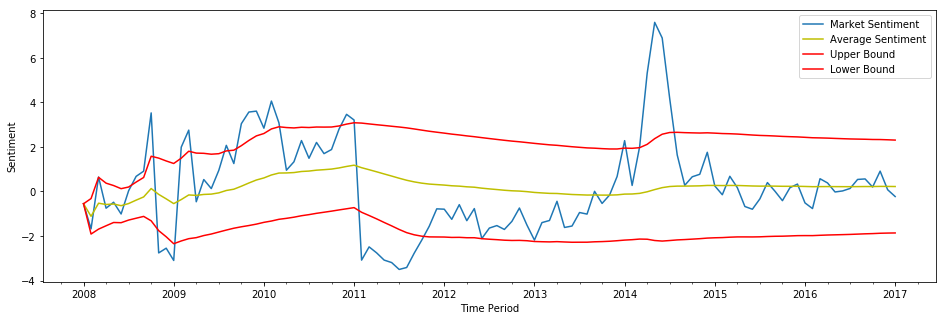

In [16]:
plt.figure(1,figsize = (16,5)) #plots the upper and lower bound of the 
ax = plt.gca()

result.plot(kind='line',y='Market Sentiment',ax=ax)
result.plot(kind='line',y='Average Sentiment', color = 'y',ax=ax)
result.plot(kind='line',y='Upper Bound', color = 'red',ax=ax)
result.plot(kind='line',y='Lower Bound', color='red', ax=ax)
plt.xlabel('Time Period')
plt.ylabel('Sentiment')
plt.show()

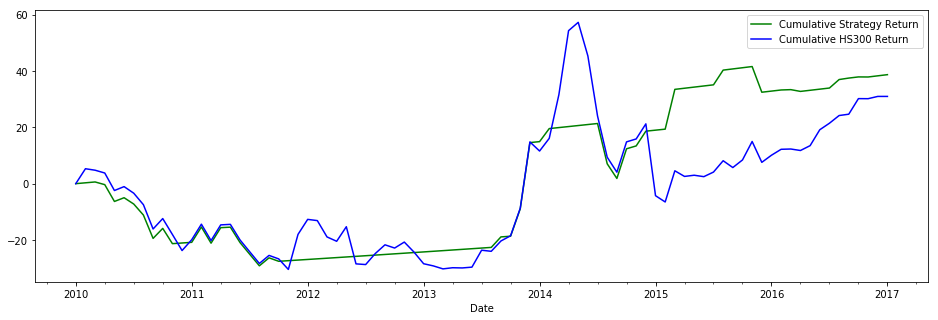

In [10]:
plt.figure(1,figsize = (16,5)) #plots the upper and lower bound of the  
ax=plt.gca()

result.plot(kind='line',y='Cumulative Strategy Return',color = 'g',ax=ax)
result.plot(kind='line',y='Cumulative HS300 Return', color = 'b',ax=ax)

In [11]:
result.tail(5)

,Market Sentiment,HS300 Index Return,Average Sentiment,st.D of Sentiment,Upper Bound,Lower Bound,risk free rate,Strategy Return,Cumulative Strategy Return,Cumulative HS300 Return
Date,,,,,,,,,,
2016-09-30,0.5638,1.0038,0.2223,2.1233,2.3456,-1.9010,1.0030,1.0038,37.4953,24.6653
2016-10-31,0.2003,1.0444,0.2221,2.1132,2.3353,-1.8910,1.0030,1.0030,37.9078,30.2005
2016-11-30,0.9137,0.9998,0.2286,2.1042,2.3328,-1.8756,1.0030,0.9998,37.8802,30.1744
2016-12-31,0.0787,1.0062,0.2272,2.0944,2.3216,-1.8672,1.0030,1.0030,38.2939,30.9815
2017-01-31,-0.2270,1.0000,0.2230,2.0852,2.3082,-1.8621,1.0030,1.0030,38.7088,30.9815


In [12]:
result[result['Strategy Return'] > result['HS300 Index Return']].count()


Market Sentiment              28
HS300 Index Return            28
Average Sentiment             28
st.D of Sentiment             28
Upper Bound                   28
Lower Bound                   28
risk free rate                28
Strategy Return               28
Cumulative Strategy Return    24
Cumulative HS300 Return       24
dtype: int64

In [13]:
result[result['Strategy Return'] < result['HS300 Index Return']].count()


Market Sentiment              36
HS300 Index Return            36
Average Sentiment             36
st.D of Sentiment             36
Upper Bound                   36
Lower Bound                   36
risk free rate                36
Strategy Return               36
Cumulative Strategy Return    26
Cumulative HS300 Return       26
dtype: int64